In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import glob
import ntpath
from hydro import objective_fxns as obx

%matplotlib inline

def wateryear(index):
    year = index.year
    strt = pd.datetime(year,10,1) # start of the next water year+1
    
    if index<strt:
        wyear = year
    elif index>=strt: 
        wyear = year+1

    return wyear

def readRHESSysBasin(filename):
    import numpy as np
    import pandas as pd
    import os.path
    import ntpath
    
    if os.path.isfile(filename) == False:
        print 'Input file does not exist'
    else:
        bd = filename # basin output path
        # split the path up and append the grow portion
        path,basename = ntpath.split(filename)
        bnparts = basename.split('_')
        bdg = path+'/'+bnparts[0]+'_'+bnparts[1]+'_grow_'+bnparts[2]

        # load the basin daily file

        bddat = pd.read_table(bd,delim_whitespace=True,
                               header='infer', parse_dates={'foo':[2,1,0]}, index_col='foo')
        bddat.reset_index(inplace=True)
        bddat.index = pd.DatetimeIndex(bddat.foo)


        if os.path.isfile(bdg):
            bdgdat = pd.read_table(bdg,delim_whitespace=True,
                               header='infer', parse_dates={'foo':[2,1,0]}, index_col='foo')
            bdgdat.reset_index(inplace=True)
            bdgdat.index = pd.DatetimeIndex(bdgdat.foo)

            data = pd.merge([bddat,bdgdat],on='foo')
            del data['foo']

        else:
            data = bddat
            del data['foo']

        return data

In [2]:
SWE = pd.read_pickle('../greenness_timing/data/niwot_snotel.pcl') # load SWE
SWE.swe *= 25.4 # convert inches to mm
SWE['wateryear']=SWE.index.map(wateryear)
SWE = SWE.loc[(SWE.wateryear>=2004) & (SWE.wateryear<=2012),:]

In [3]:
dat2 = readRHESSysBasin('/RHESSys/ComoCreek_new/out/snow2/snow_cal2_12835_basin.daily')
dat2['wateryear'] = dat2.index.map(wateryear)
dat2 = dat2.loc[(dat2.wateryear>=2004) & (dat2.wateryear<=2012),:]

dat2['accumS'] = np.NaN

for wy in dat2.wateryear:
    dat2.loc[dat2.wateryear==wy,'accumS']=dat2.loc[dat2.wateryear==wy,'snowfall'].cumsum()

In [7]:
ct = 0

In [5]:
ct = 26

In [6]:
def hydroR2(observed,simulated):
    '''Computes the R2 for each water year a simulation covers and returns the mean value. Inputs must consist of whole water years.'''
    obs = observed
    sim = simulated
    
    obs = pd.DataFrame({'val':obs.as_matrix()},index=obs.index)
    sim = pd.DataFrame({'val':sim.as_matrix()},index=sim.index)
    
    obs['wateryear']=obs.index.map(wateryear)
    sim['wateryear']=sim.index.map(wateryear)
    
    r2s = []
    for wy in np.unique(obs.wateryear):
        ys = obs.loc[obs.wateryear==wy,'val'].as_matrix()
        yhats = sim.loc[sim.wateryear==wy,'val'].as_matrix()

        meanval = np.nanmean(ys) # compute the mean of the observations

        upp = []
        lower = []
        for y,yh in zip(ys,yhats):
            upp.append((y-yh)**2)
            lower.append((y-meanval)**2)

        r2s.append(1-(np.nansum(upp)/np.nansum(lower)))

    r2 = np.nanmean(r2s)
    return r2

In [135]:
whdr = '-whdr /RHESSys/ComoCreek_new/worldfiles/world.como.lai.hdr '
w = '-w /RHESSys/ComoCreek_new/worldfiles/world.niwot.noveg '
t = '-t /RHESSys/ComoCreek_new/tecfiles/snow.tec '
strt = '-st 2003 10 1 1 '
nd = '-ed 2013 09 30 1 '
f = '-r /RHESSys/ComoCreek_new/flowtables/niwot.flow '
soil = '-s 15 15 -gw 0.1 0.5 '
flg = '-b '
prog = 'rhessys5.19 '
pre = '-pre /RHESSys/ComoCreek_new/out/snow/snow_cal5_'+str(ct)

cmd = prog+w+whdr+t+strt+nd+f+soil+flg+pre
print cmd
os.system(cmd)
ct = ct+1

rhessys5.19 -w /RHESSys/ComoCreek_new/worldfiles/world.niwot.noveg -whdr /RHESSys/ComoCreek_new/worldfiles/world.como.lai.hdr -t /RHESSys/ComoCreek_new/tecfiles/snow.tec -st 2003 10 1 1 -ed 2013 09 30 1 -r /RHESSys/ComoCreek_new/flowtables/niwot.flow -s 15 15 -gw 0.1 0.5 -b -pre /RHESSys/ComoCreek_new/out/snow/snow_cal5_42


In [136]:
fl = '/RHESSys/ComoCreek_new/out/snow/snow_cal5_'+str(ct-1)+'_basin.daily'
dat = readRHESSysBasin(fl)
dat['wateryear'] = dat.index.map(wateryear)
dat = dat.loc[(dat.wateryear>=2004) & (dat.wateryear<=2012),:]
print fl,'Loaded'

dat['accumP'] = np.NaN
dat['accumS'] = np.NaN
for wy in np.unique(dat.wateryear):
    dat.loc[dat.wateryear==wy,'accumP']=dat.loc[dat.wateryear==wy,'precip'].cumsum()
    dat.loc[dat.wateryear==wy,'accumS']=dat.loc[dat.wateryear==wy,'snowfall'].cumsum()
pth,basename = ntpath.split(fl)
prts = basename.split('_')
zonepth = pth+'/'+prts[0]+'_'+prts[1]+'_'+prts[2]+'_zone_zone.params'
soilpth = pth+'/'+prts[0]+'_'+prts[1]+'_'+prts[2]+'_sandyloam_soil.params'

print zonepth
print soilpth

z = {}
with open(zonepth) as f:
    for line in f:
        (val,key) = line.split(None)
        z[key]=val

s = {}
with open(soilpth) as f:
    for line in f:
        (val,key) = line.split(None)
        s[key]=val

        
print z['max_snow_temp'],'max_snow_temp'
print z['min_rain_temp'],'min_rain_temp'
print z['temcf'],'temcf'
print s['maximum_snow_energy_deficit'],'maximum_snow_energy_deficit'
print s['snow_melt_Tcoef'],'snow_melt_Tcoef'
print round(obx.nashsut(SWE.swe,dat.snowpack),2), 'SWE NSE'
print round(obx.percenterror(SWE.swe,dat.snowpack),2), 'SWE Percent Error'
print round(hydroR2(SWE.swe,dat.snowpack),2), 'SWE R2'

/RHESSys/ComoCreek_new/out/snow/snow_cal5_42_basin.daily Loaded
/RHESSys/ComoCreek_new/out/snow/snow_cal5_42_zone_zone.params
/RHESSys/ComoCreek_new/out/snow/snow_cal5_42_sandyloam_soil.params
2.0 max_snow_temp
0.0 min_rain_temp
0.4 temcf
-30.0 maximum_snow_energy_deficit
0.0005 snow_melt_Tcoef
0.92 SWE NSE
0.29 SWE Percent Error
0.91 SWE R2


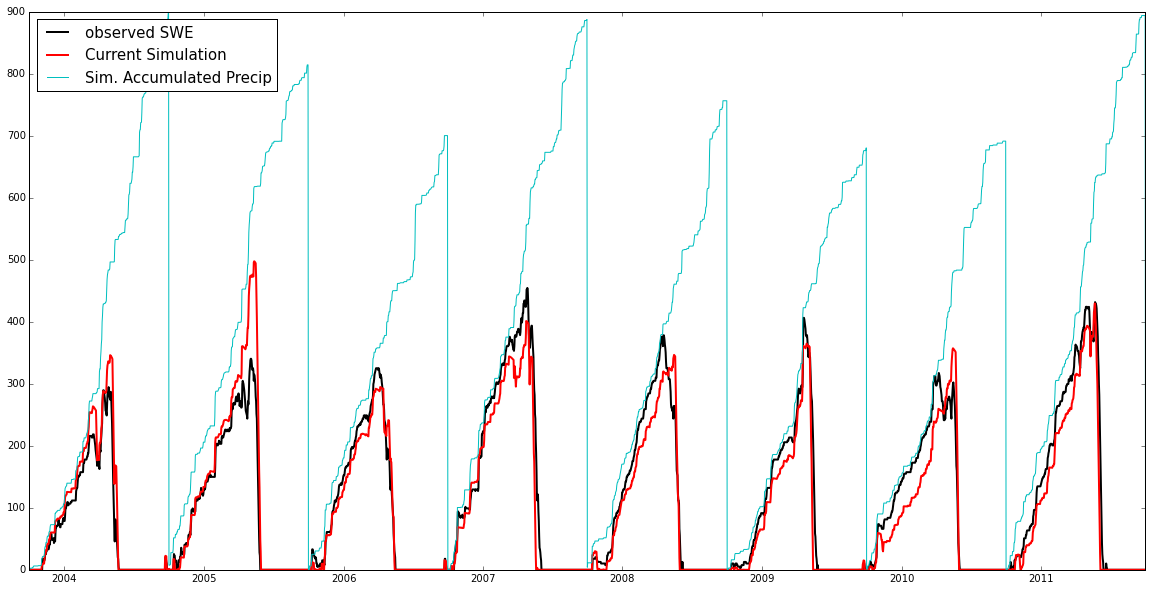

In [137]:
plt.figure(figsize=(20,10))
plt.plot(SWE.index,SWE.swe,'-k',lw=2) # obs
plt.plot(dat.index,dat.snowpack,'-r',lw=2) # current simulation SWE
plt.plot(dat.index,dat.accumP,'-c') # current simulation precip.
plt.legend(['observed SWE','Current Simulation','Sim. Accumulated Precip'], fontsize=15,loc='best')
plt.xlim('2003-10-1','2011-9-30')
# '-2 - 2 SWE','-2 - 2 Snowfall','Sim. Accumulated Snowfall','Sim. Snowmelt'
plt.savefig('/RHESSys/ComoCreek_new/figures/snow_test.png',bbox_inches='tight')

In [543]:
dat.snowpack.describe()

count    2912.000000
mean        8.544002
std        41.093641
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       371.223105
Name: snowpack, dtype: float64

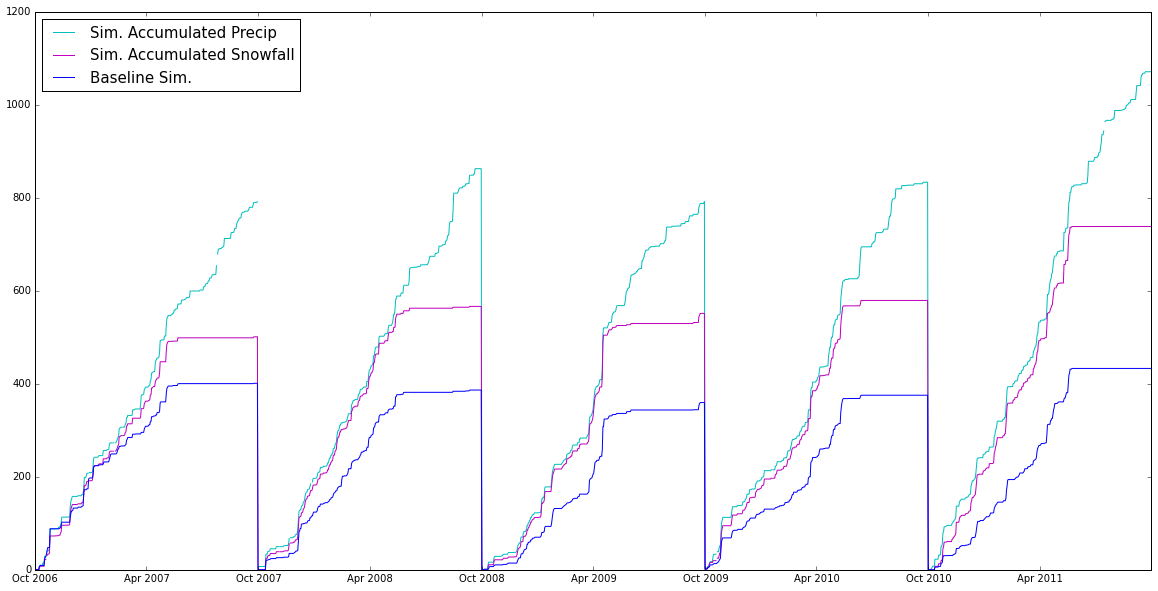

In [544]:
plt.figure(figsize=(20,10))
plt.plot(dat.index,dat.accumP,'-c')
plt.plot(dat.index,dat.accumS,'-m')
plt.plot(dat2.index,dat2.accumS,'-b')
plt.legend(['Sim. Accumulated Precip','Sim. Accumulated Snowfall','Baseline Sim.'], fontsize=15,loc='best')
plt.xlim('2006-10-1','2011-9-30');

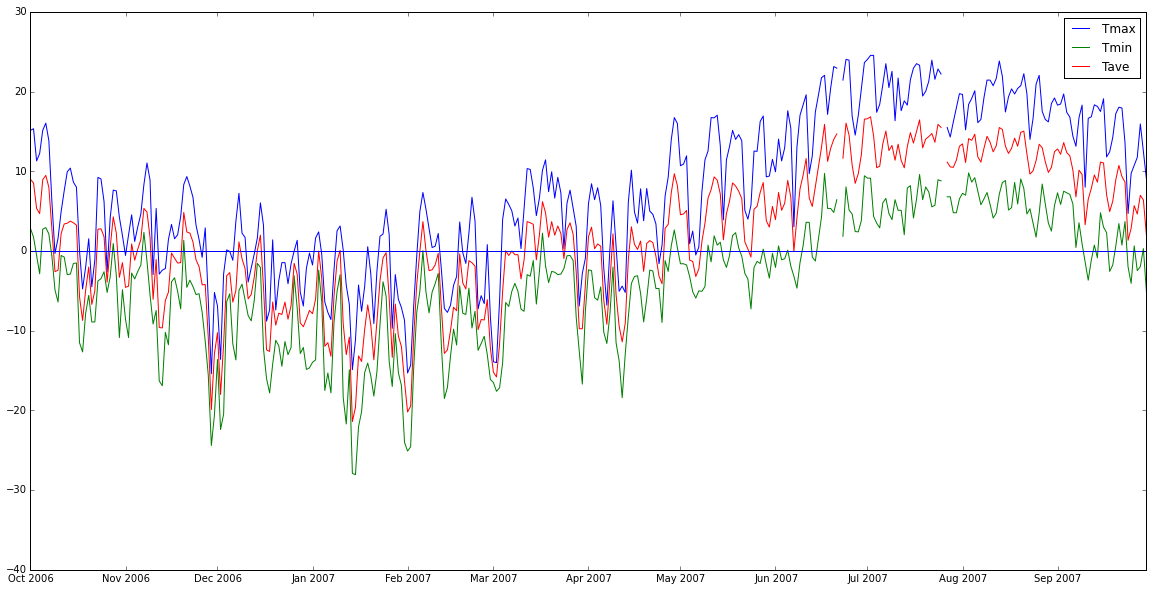

In [545]:
plt.figure(figsize=(20,10))
plt.plot(dat.index,dat.tmax)
plt.plot(dat.index,dat.tmin)
plt.plot(dat.index,dat.tavg)
plt.axhline(0)
plt.xlim('2006-10-1','2007-9-30')
plt.legend(['Tmax','Tmin','Tave'])

(732585.0, 732949.0)

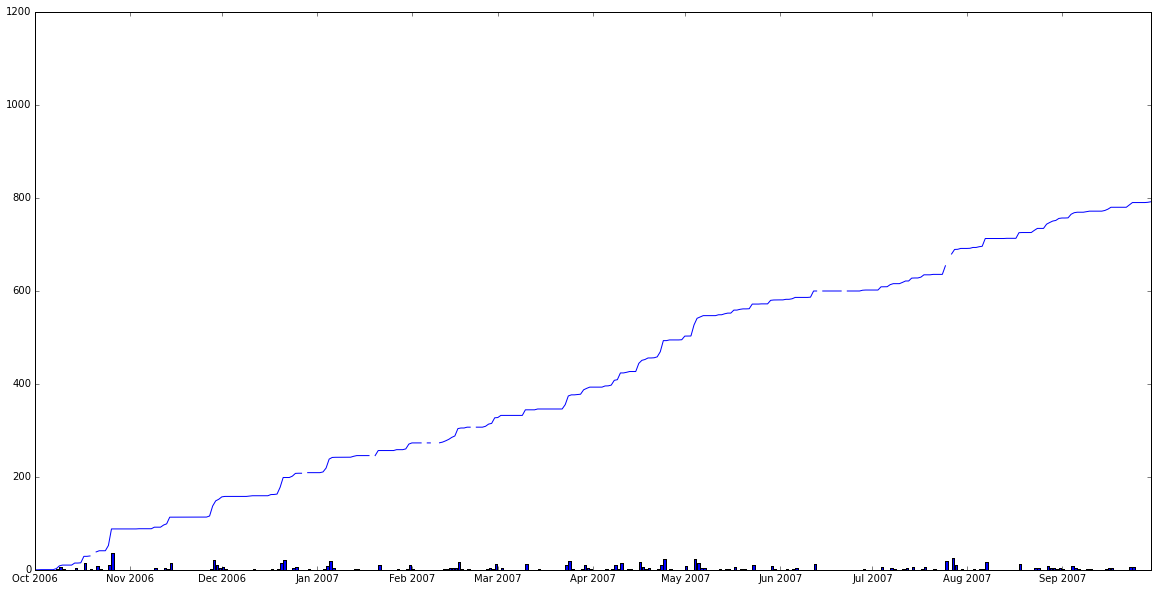

In [546]:
plt.figure(figsize=(20,10))
plt.bar(dat.index,dat.precip)
plt.plot(dat.index,dat.accumP)
plt.axhline(0)
plt.xlim('2006-10-1','2007-9-30')

In [547]:
strt = '2006-10-1'
nd = '2007-9-30'

(-30, 30)

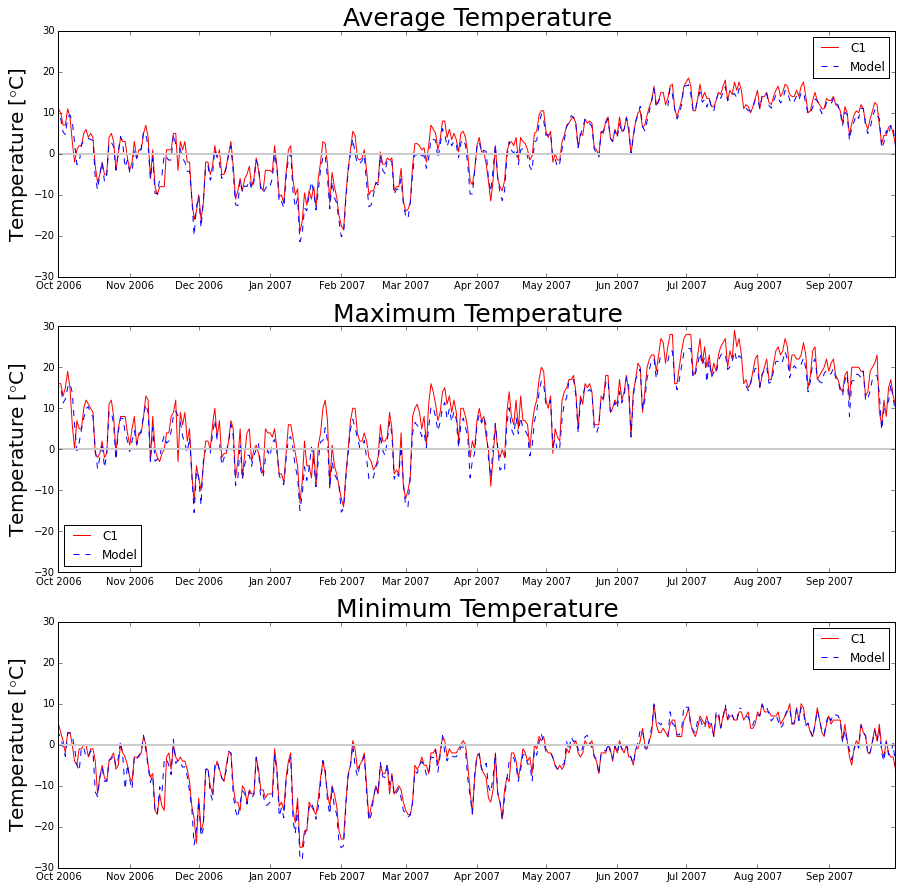

In [548]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(311)
ax.plot(c1.index,c1.Tave,'-r',dat.index,dat.tavg,'--b')
plt.xlim(strt,nd)
plt.legend(['C1','Model'])
plt.axhline(0,c='0.8',lw=2)
ax.set_ylabel('Temperature [$\degree$C]', fontsize=20)
ax.set_title('Average Temperature',fontsize=25)
ax.set_ylim(-30,30)

ax = fig.add_subplot(312)
ax.plot(c1.index,c1.Tmax,'-r',dat.index,dat.tmax,'--b')
plt.xlim(strt,nd)
plt.legend(['C1','Model'],loc='best')
plt.axhline(0,c='0.8',lw=2)
ax.set_ylabel('Temperature [$\degree$C]', fontsize=20)
ax.set_title('Maximum Temperature',fontsize=25)
ax.set_ylim(-30,30)

ax = fig.add_subplot(313)
ax.plot(c1.index,c1.Tmin,'-r',dat.index,dat.tmin,'--b')
plt.xlim(strt,nd)
plt.legend(['C1','Model'])
plt.axhline(0,c='0.8',lw=2)
ax.set_ylabel('Temperature [$\degree$C]', fontsize=20)
ax.set_title('Minimum Temperature',fontsize=25)
ax.set_ylim(-30,30)

In [244]:
c1['wateryear'] = c1.index.map(wateryear)

In [246]:
c1['accumP']=np.NaN
for wy in c1.wateryear:
    c1.loc[c1.wateryear==wy,'accumP']=c1.loc[c1.wateryear==wy,'P'].cumsum()

(732585.0, 732949.0)

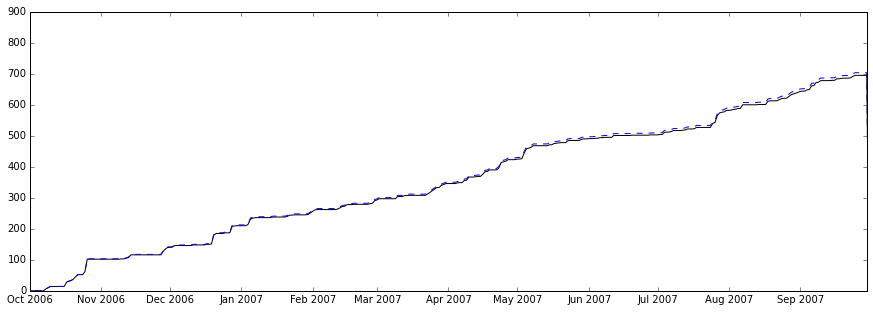

In [262]:
fig = plt.figure(figsize=(15,5))
plt.plot(c1.index,c1.accumP*1000,'-k')
plt.plot(dat.index,dat.accumP,'--b')
plt.xlim(strt,nd)